In [2]:
import logging
from binance.um_futures import UMFutures as Client
from binance.lib.utils import config_logging
from binance.error import ClientError
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import os
from scipy import signal

In [81]:
#PARAMETERS
TIMEFRAME = "12h"
PAIR = "ETHUSDT"
DATA_WINDOW_LENGTH = 1000
ROLLING_WINDOW_LENGTH = 12 #this is correlated with the chosen TIMEFRAME and as such should be a function of that; something about the frequency of local minima and maxima
CALLBACKRATE_FACTOR = 10

In [82]:
akey = os.environ.get("API_KEY")
asec = os.environ.get("API_SECRET")

In [83]:
config_logging(logging, logging.DEBUG)
futures_client = Client(key = akey, secret= asec)
# logging.info(futures_client.continuous_klines("BTCUSDT", 'PERPETUAL', '15m', limit=100));
klines = futures_client.continuous_klines(PAIR, 'PERPETUAL', TIMEFRAME, limit=DATA_WINDOW_LENGTH);

In [84]:
def process_klines(klines):

    df = pd.DataFrame(klines)
    df.columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'trades', 'taker_buy_volume', 'taker_buy_quote_asset_volume', 'ignore']
    df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
    df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
    df['open'] = pd.to_numeric(df['open'])
    df['high'] = pd.to_numeric(df['high'])
    df['low'] = pd.to_numeric(df['low'])
    df['close'] = pd.to_numeric(df['close'])
    df['volume'] = pd.to_numeric(df['volume'])
    df['quote_asset_volume'] = pd.to_numeric(df['quote_asset_volume'])
    df['trades'] = pd.to_numeric(df['trades'])
    df['taker_buy_volume'] = pd.to_numeric(df['taker_buy_volume'])
    df['taker_buy_quote_asset_volume'] = pd.to_numeric(df['taker_buy_quote_asset_volume'])
    df['ignore'] = pd.to_numeric(df['ignore'])
    df.drop(['ignore'], axis=1, inplace=True)
    return df

In [85]:
df = process_klines(klines)

In [86]:
closes_mean = df.close.ewm(halflife=pd.Timedelta(TIMEFRAME)/4, ignore_na=True, min_periods=ROLLING_WINDOW_LENGTH, times=df.open_time).mean()
closes_std = df.close.ewm(halflife=pd.Timedelta(TIMEFRAME)/4, ignore_na=True, min_periods=ROLLING_WINDOW_LENGTH, times=df.open_time).std()
mean_std = closes_std.mean()
closes_mean.mean(), mean_std

(2677.6049435609457, 73.60012136528377)

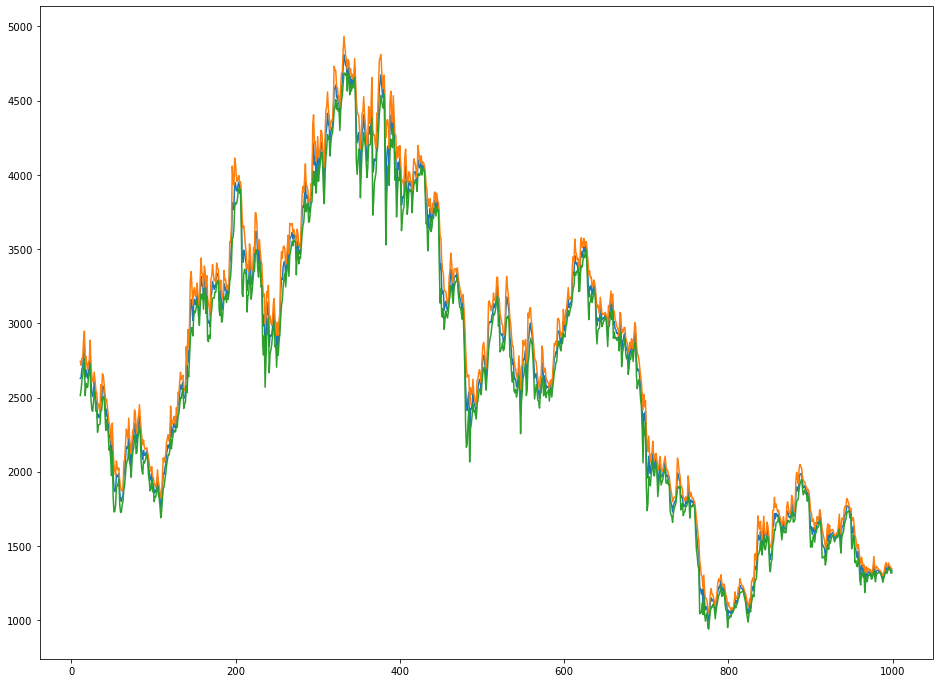

In [87]:
(fig, ax) = plt.subplots(figsize=(16,12))
ax.plot(closes_mean)
ax.plot(closes_mean + closes_std)
ax.plot(closes_mean - closes_std)

In [88]:
peak_indexes = signal.argrelextrema(df.close.values, np.greater)
peak_indexes = peak_indexes[0]

valley_indexes = signal.argrelextrema(df.close.values, np.less)
valley_indexes = valley_indexes[0]

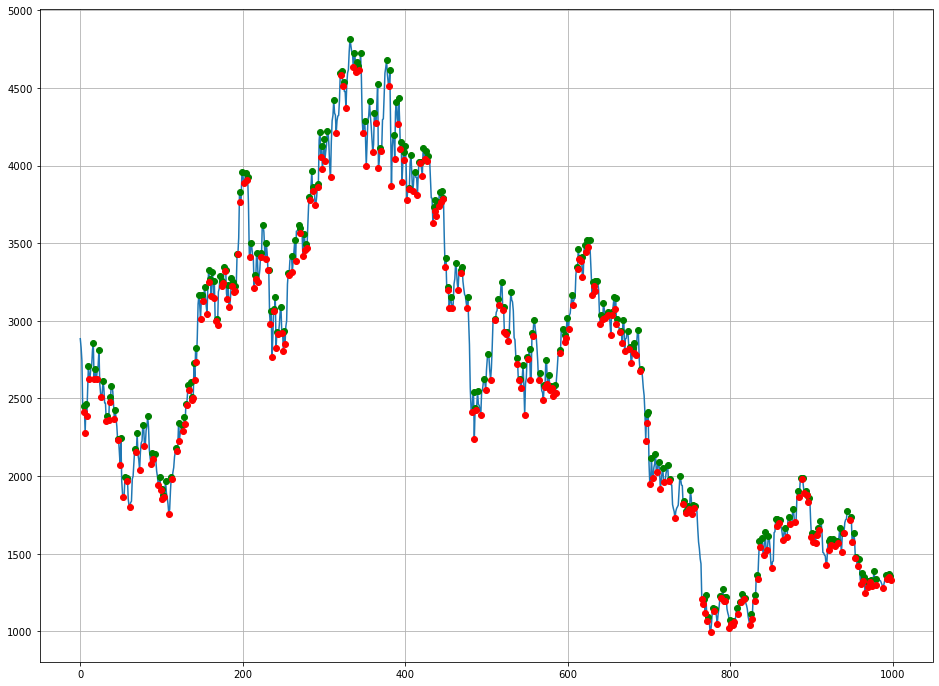

In [89]:
# plot peaks
(fig, ax) = plt.subplots(figsize=(16,12))
ax.plot(df.close)

peak_x = peak_indexes
peak_y = df.close.values[peak_indexes]
ax.plot(peak_x, peak_y, marker='o', linestyle="None", color='green', label="Peaks")
 
# plot valleys
valley_x = valley_indexes
valley_y = df.close.values[valley_indexes]
ax.plot(valley_x, valley_y, marker='o', linestyle="None", color='red', label="Valleys")

ax.grid()

In [90]:
(-1)*df.close.values

array([-2884.27, -2828.05, -2742.77, -2437.11, -2411.66, -2449.95,
       -2277.99, -2462.35, -2386.11, -2552.  , -2706.33, -2624.15,
       -2634.63, -2695.34, -2707.22, -2808.22, -2858.34, -2624.99,
       -2689.21, -2640.25, -2627.45, -2690.5 , -2711.4 , -2812.61,
       -2592.96, -2531.57, -2506.19, -2534.44, -2610.2 , -2565.25,
       -2471.11, -2468.92, -2354.25, -2388.14, -2370.59, -2362.08,
       -2508.71, -2478.46, -2579.82, -2576.96, -2544.17, -2460.65,
       -2366.84, -2424.43, -2372.51, -2318.88, -2231.68, -2240.15,
       -2163.36, -2072.59, -2242.7 , -1969.02, -1884.77, -1866.03,
       -1878.46, -1990.38, -1966.51, -1964.99, -1989.5 , -1852.84,
       -1808.  , -1800.4 , -1828.88, -1837.58, -1980.83, -1998.86,
       -2083.56, -2174.03, -2165.15, -2155.64, -2275.  , -2137.74,
       -2105.24, -2038.  , -2152.64, -2212.5 , -2226.63, -2329.61,
       -2321.95, -2194.58, -2195.38, -2292.51, -2322.04, -2383.6 ,
       -2314.65, -2168.3 , -2114.88, -2080.19, -2147.53, -2109

In [91]:

# peak_indexes, _ = signal.find_peaks(df.close.values, threshold=mean_std/2)
# peak_indexes, _ = signal.find_peaks(df.close.values, prominence=1.5*mean_std)
peak_indexes, _ = signal.find_peaks(df.close.values, prominence=1.5*mean_std)
print(peak_indexes)

# valley_indexes, _ = signal.find_peaks(-1*df.close.values, threshold=mean_std/2)
# valley_indexes, _ = signal.find_peaks(-1*df.close.values, prominence=1.5*mean_std)
valley_indexes, _ = signal.find_peaks((-1)*df.close.values, prominence=1.5*mean_std)
print(valley_indexes)

[ 16  23  38  50  55  70  77  83 105 121 136 146 153 158 162 165 177 199
 217 225 240 247 264 269 285 295 300 304 312 322 332 345 356 366 377 386
 389 392 400 407 412 422 445 462 470 484 489 502 519 530 545 553 559 573
 613 627 644 657 668 674 686 699 703 708 723 738 751 770 791 814 839 843
 856 889 911 935 944 977]
[  6  17  32  49  53  61  73  79 101 109 122 137 148 156 161 164 169 183
 214 219 236 241 250 265 274 289 298 301 308 315 327 339 352 360 367 383
 387 391 396 402 409 415 434 454 465 482 485 493 505 526 542 547 554 570
 582 618 640 653 667 670 678 696 701 705 714 732 745 769 776 799 824 841
 851 865 905 918 937 966]


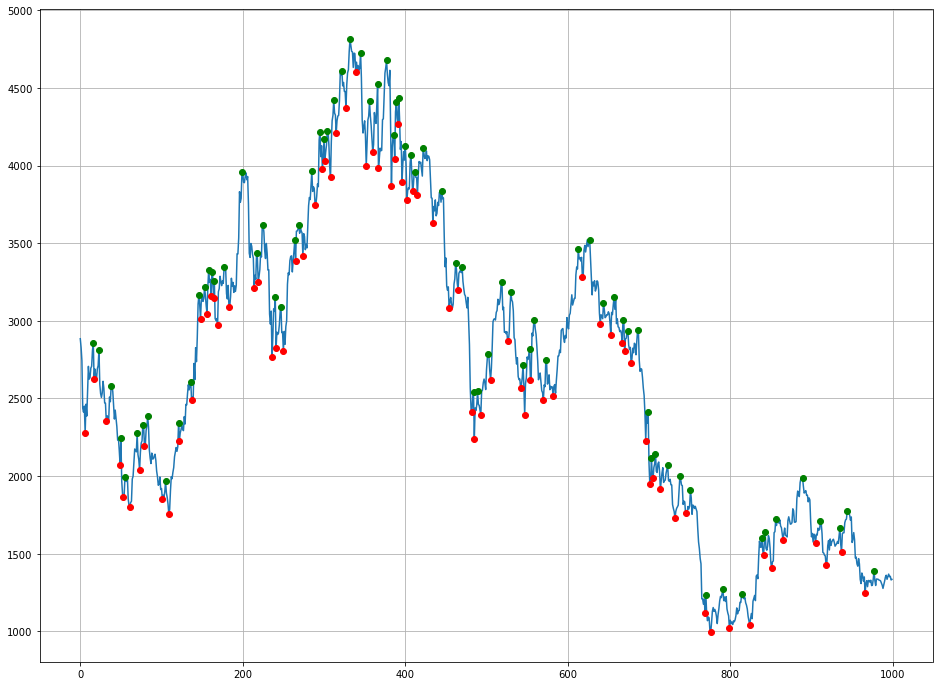

In [92]:
# plot peaks
(fig, ax) = plt.subplots(figsize=(16,12))
ax.plot(df.close)

peak_x = peak_indexes
peak_y = df.close.values[peak_indexes]
ax.plot(peak_x, peak_y, marker='o', linestyle="None", color='green', label="Peaks")
 
# plot valleys
valley_x = valley_indexes
valley_y = df.close.values[valley_indexes]
ax.plot(valley_x, valley_y, marker='o', linestyle="None", color='red', label="Valleys")

ax.grid()

In [93]:
peak_regions = []
for peak_index in peak_indexes:
    peak_regions.append(peak_index)
    for j in range(min(max(peak_index+1, len(df.close.values) - max(peak_indexes)), 5)):
        if np.abs(df.close.values[peak_index-j] - df.close.values[peak_index]) < mean_std/4:
            peak_regions.append(peak_index-j)
        elif np.abs(df.close.values[peak_index+j] - df.close.values[peak_index]) < mean_std/4:
            peak_regions.append(peak_index+j)        
print(len(peak_regions) - len(peak_indexes))
valley_regions = []
for valley_index in valley_indexes:
    for j in range(min(valley_index+1, len(df.close.values) - max(valley_indexes))):
        if np.abs(df.close.values[valley_index-j] - df.close.values[valley_index]) < mean_std/4:
            valley_regions.append(valley_index-j)
        elif np.abs(df.close.values[valley_index+j] - df.close.values[valley_index]) < mean_std/4:
            valley_regions.append(valley_index+j)    
print(len(valley_regions) - len(valley_indexes))

118
161


In [94]:
len(peak_regions) - len(peak_indexes)

118

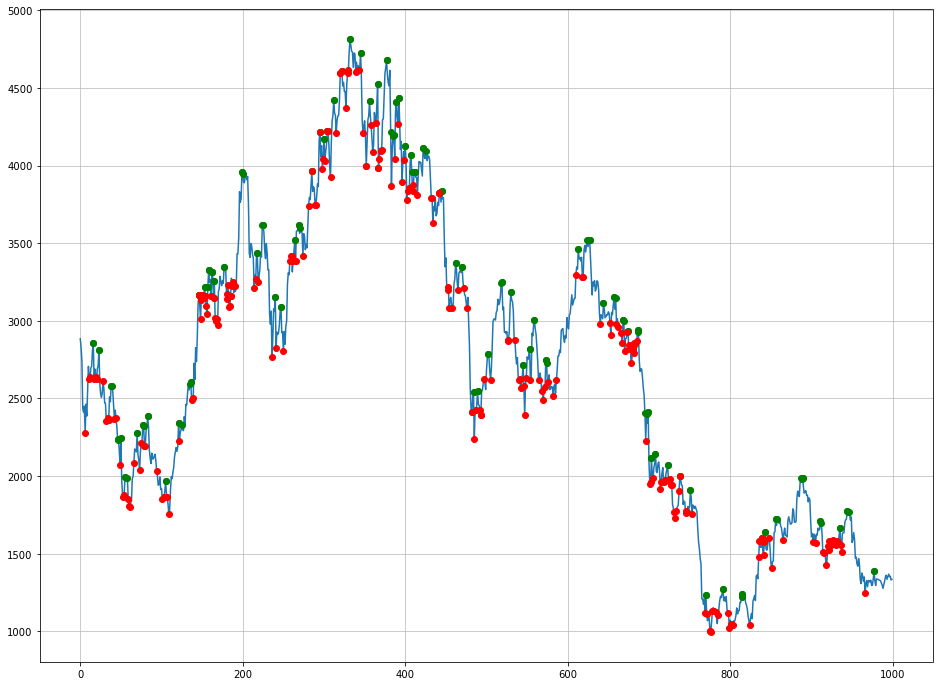

In [95]:
(fig, ax) = plt.subplots(figsize=(16,12))
ax.plot(df.close)

peak_x = peak_regions
peak_y = df.close.values[peak_regions]
ax.plot(peak_x, peak_y, marker='o', linestyle="None", color='green', label="Peaks")

valley_x = valley_regions
valley_y = df.close.values[valley_regions]
ax.plot(valley_x, valley_y, marker='o', linestyle="None", color='red', label="Valleys")
ax.grid(which='both', alpha=0.8)
ax.grid(True, which="minor")
